# Sketch2Shoe - Generating Photorealistic Footwear from Edge Maps

In [1]:
import os, random, pathlib, tarfile, urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode, functional as TF
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

C:\Users\NYUAD\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the Dataset

In [2]:
# dataset_name = "edges2shoes"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# # Download and extract the dataset
# def download_and_extract(url, download_path):
#     if not download_path.exists():
#         print(f"Downloading {url}...")
#         tar_path, _ = urllib.request.urlretrieve(url)
#         print(f"Extracting to {download_path}...")
#         with tarfile.open(tar_path, "r:gz") as tar:
#             tar.extractall(path=download_path.parent)
#     else:
#         print(f"{dataset_name} already downloaded.")

# # Set paths
# base_path = pathlib.Path('./data')
# download_path = base_path / dataset_name
# base_path.mkdir(exist_ok=True)

# download_and_extract(_URL, download_path)

# # Now dataset is available at:
# print("Dataset path:", download_path)

## Data Preprocessing

In [3]:
full_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((256, 512)),           
    transforms.RandomVerticalFlip(p=0.5),          
])

to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [4]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, mode='train',
                 full_transform=None, to_tensor=None, max_images=None):
        files = sorted((pathlib.Path(root_dir)/mode).glob("*.jpg"))
        if max_images is not None:
            files = files[:max_images]
        self.files = files

        self.full_transform = full_transform
        self.to_tensor = to_tensor

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = PILImage.open(self.files[idx]).convert("RGB")
        if self.full_transform:
            img = self.full_transform(img)

        w, h = img.size
        w2 = w // 2
        sketch_img = img.crop((0, 0, w2, h))
        shoe_img   = img.crop((w2, 0, w,  h))

        if self.to_tensor:
            sketch_img = self.to_tensor(sketch_img)
            shoe_img   = self.to_tensor(shoe_img)

        return sketch_img, shoe_img

In [5]:
# Build the loaders
train_ds = Pix2PixDataset(
    './data/edges2shoes',
    mode='train',
    full_transform=full_transform,
    to_tensor=to_tensor_norm,
    max_images=10_000
)

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=0)

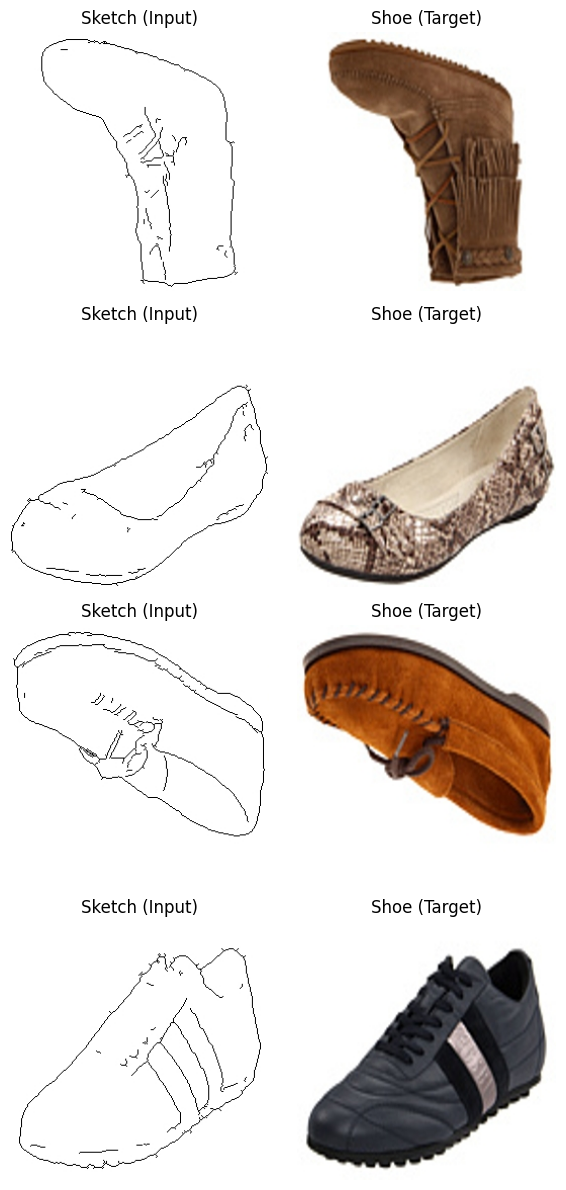

In [6]:
# Visualize a few samples
fig, axes = plt.subplots(4, 2, figsize=(6, 12))
for i, (sketch, shoe) in enumerate(train_dl):
    if i == 4: break

    sk = sketch * 0.5 + 0.5
    sh = shoe   * 0.5 + 0.5

    axes[i, 0].imshow(sk[0].permute(1, 2, 0))
    axes[i, 0].set_title("Sketch (Input)")

    axes[i, 1].imshow(sh[0].permute(1, 2, 0))
    axes[i, 1].set_title("Shoe (Target)")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

## Discriminator Network

In [7]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        # Since we concatenate two images, the first conv sees in_channels*2
        self.model = nn.Sequential(
        # → (in_channels*2) x 256 x 256
        nn.Conv2d(in_channels * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # → base_features x 128 x 128

        nn.Conv2d(base_features, base_features*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*2),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*2) x 64 x 64

        nn.Conv2d(base_features*2, base_features*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*4),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*4) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*4) x 34 x 34

        nn.Conv2d(base_features*4, base_features*8, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(base_features*8),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*8) x 32 x 32

        # final “patch” conv; produces a 31×31 score map
        nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1, bias=False),
        # → 1 x 31 x 31
        nn.Sigmoid(),
        )

    def forward(self, real_input, real_target):
        x = torch.cat([real_input, real_target], dim = 1)  
        return self.model(x)

## Generator Network

In [8]:
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # --- ENCODER (downsampling) ---
        # 256→128
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
        )

        # 128→64
        self.enc2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2)
        )
        # 64→32
        self.enc3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4)
        )
        # 32→16
        self.enc4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 16→8
        self.enc5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 8→4
        self.enc6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 4→2
        self.enc7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False)
        )

        # --- DECODER (upsampling) ---
        # 1→2
        self.dec1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 2→4 (cat → 16 channels in)
        self.dec2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 4→8
        self.dec3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 8→16
        self.dec4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4)
        )
        # 16→32 (cat 16+16→32 channels)
        self.dec5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 4 * 2, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2)
        )
        # 32→64
        self.dec6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 2 * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features)
        )
        # 64→128
        self.dec7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        d1 = torch.cat([self.dec1(e7), e6], dim=1)
        d2 = torch.cat([self.dec2(d1), e5], dim=1)
        d3 = torch.cat([self.dec3(d2), e4], dim=1)
        d4 = torch.cat([self.dec4(d3), e3], dim=1)
        d5 = torch.cat([self.dec5(d4), e2], dim=1)
        d6 = torch.cat([self.dec6(d5), e1], dim=1)

        return self.dec7(d6)

## Discriminator Training

In [9]:
def train_discriminator(discriminator, generator, sketch_images, shoe_images, opt_d):
    discriminator.train()
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # ——— Real pairs ———
    # D(sketch, shoe) should predict “real” → target=1
    real_preds = discriminator(sketch_images, shoe_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = 0.5 * F.binary_cross_entropy(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(sketch) → fake; detach so G’s grad isn’t updated here
    fake_images = generator(sketch_images).detach()
    fake_preds = discriminator(sketch_images, fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss    = 0.5 * F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = fake_preds.mean().item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score


## Generator Training

In [10]:
def train_generator(discriminator, generator, sketch_images, shoe_images, opt_g, lambda_L1=100):
    generator.train()

    loss_total = 0.0
    adv_total = 0.0
    l1_total = 0.0

    # Train G twice per D step
    for _ in range(2):  
        # Clear generator gradients                                     
        opt_g.zero_grad()

        # 1) Adversarial loss
        # Generate fake images
        fake_images = generator(sketch_images)

        # Try to fool the discriminator
        preds = discriminator(sketch_images, fake_images)
        targets = torch.ones_like(preds)
        adv_loss = F.binary_cross_entropy(preds, targets)

        # 2) L1 reconstruction loss
        l1_loss = F.l1_loss(fake_images, shoe_images, reduction="mean")

        total_loss = adv_loss + (lambda_L1 * l1_loss)

        total_loss.backward()
        opt_g.step()

        loss_total += total_loss.item()
        adv_total += adv_loss.item()
        l1_total += l1_loss.item()

    # Average over the two updates
    return loss_total / 2, adv_total / 2, l1_total / 2


In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

In [12]:
# Save Samples
def save_samples(epoch_idx, sketch_batch, generator, denorm_fn, show=False):
    generator.eval()

    with torch.no_grad():
        fake = generator(sketch_batch)

    fake = denorm_fn(fake)
    fname = f'generated-images-{epoch_idx:04d}.png'
    save_image(fake, os.path.join('generated', fname), nrow=8)
    print('Saved', fname)

    if show:
        grid = make_grid(fake.cpu(), nrow=8)
        plt.figure(figsize=(8,8)); plt.axis('off'); plt.imshow(grid.permute(1,2,0)); plt.show()


## Full Training Loop

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [15]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias, 0)

In [16]:
def fit(
    discriminator: nn.Module,
    generator:     nn.Module,
    train_dl,
    fixed_sketches,        # a batch of sketch images, e.g. next(iter(val_dl))
    denorm,                # function mapping [-1,1]→[0,1]
    device = None,
    epochs = 200,
    lr = 2e-4,
    start_idx = 1,
    lambda_L1 = 100
):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
   
    # ── LR schedulers: decay LR by 0.5 every 25 epochs ──
    sched_d = torch.optim.lr_scheduler.StepLR(opt_d, step_size=25, gamma=0.5)
    sched_g = torch.optim.lr_scheduler.StepLR(opt_g, step_size=25, gamma=0.5)

    for epoch in range(start_idx, start_idx + epochs):
        sum_d = sum_g = 0.0
        sum_real_s = sum_fake_s = 0.0
        n = 0

        for sketch_images, shoe_images in tqdm(train_dl, desc=f"Epoch {epoch}/{start_idx+epochs-1}"):
            # — Train D —
            d_loss, real_s, fake_s = train_discriminator(
                discriminator, generator,
                sketch_images, shoe_images,
                opt_d
            )

            # — Train G —
            g_loss, adv_loss, l1_loss = train_generator(
                discriminator, generator,
                sketch_images, shoe_images,
                opt_g, lambda_L1
            )

            sum_d       += d_loss
            sum_g       += g_loss
            sum_real_s  += real_s
            sum_fake_s  += fake_s
            n           += 1

        # Averages
        avg_d = sum_d / n
        avg_g = sum_g / n
        avg_real = sum_real_s / n
        avg_fake = sum_fake_s / n

        # Record losses & scores
        losses_d.append(avg_d)
        losses_g.append(avg_g)
        real_scores.append(avg_real)
        fake_scores.append(avg_fake)

        # Log losses & scores (last batch)
        print(
            f"Epoch [{epoch}]  "
            f"loss_g: {avg_g:.4f}, loss_d: {avg_d:.4f}, "
            f"real_score: {avg_real:.4f}, fake_score: {avg_fake:.4f}"
        )

        # Save generated images
        save_samples(epoch, fixed_sketches, generator, denorm)

        # Step the schedulers each epoch
        sched_d.step()
        sched_g.step()

        if epoch % 5 == 0:
            torch.save(generator.state_dict(), f"checkpoint_gen_epoch{epoch}.pth")

    return losses_g, losses_d, real_scores, fake_scores


In [17]:
discriminator = Pix2PixDiscriminator()
generator     = Pix2PixGenerator()
fixed_sketches, _ = next(iter(train_dl))

history1 = fit(
    discriminator=discriminator,
    generator=generator,
    train_dl=train_dl,
    fixed_sketches=fixed_sketches,
    denorm=denorm,
    device=None,
    epochs=100,
    lr=2e-4,
    start_idx=1,
    lambda_L1 = 100
)

Epoch 1/100: 100%|██████████| 10000/10000 [2:25:49<00:00,  1.14it/s] 


Epoch [1]  loss_g: 20.0971, loss_d: 0.4766, real_score: 0.6877, fake_score: 0.3108
Saved generated-images-0001.png


Epoch 2/100: 100%|██████████| 10000/10000 [2:31:04<00:00,  1.10it/s] 


Epoch [2]  loss_g: 17.7856, loss_d: 0.4312, real_score: 0.7211, fake_score: 0.2782
Saved generated-images-0002.png


Epoch 3/100: 100%|██████████| 10000/10000 [2:34:27<00:00,  1.08it/s] 


Epoch [3]  loss_g: 16.5794, loss_d: 0.4210, real_score: 0.7292, fake_score: 0.2702
Saved generated-images-0003.png


Epoch 4/100: 100%|██████████| 10000/10000 [2:30:42<00:00,  1.11it/s] 


Epoch [4]  loss_g: 15.8821, loss_d: 0.3731, real_score: 0.7563, fake_score: 0.2433
Saved generated-images-0004.png


Epoch 5/100: 100%|██████████| 10000/10000 [2:26:31<00:00,  1.14it/s] 


Epoch [5]  loss_g: 15.7582, loss_d: 0.2981, real_score: 0.8070, fake_score: 0.1926
Saved generated-images-0005.png


Epoch 6/100: 100%|██████████| 10000/10000 [2:26:24<00:00,  1.14it/s] 


Epoch [6]  loss_g: 15.2248, loss_d: 0.2984, real_score: 0.8080, fake_score: 0.1916
Saved generated-images-0006.png


Epoch 7/100: 100%|██████████| 10000/10000 [2:28:46<00:00,  1.12it/s] 


Epoch [7]  loss_g: 14.6467, loss_d: 0.3147, real_score: 0.7993, fake_score: 0.2003
Saved generated-images-0007.png


Epoch 8/100: 100%|██████████| 10000/10000 [2:28:53<00:00,  1.12it/s] 


Epoch [8]  loss_g: 14.2047, loss_d: 0.3249, real_score: 0.7935, fake_score: 0.2061
Saved generated-images-0008.png


Epoch 9/100: 100%|██████████| 10000/10000 [2:25:43<00:00,  1.14it/s] 


Epoch [9]  loss_g: 13.7378, loss_d: 0.3305, real_score: 0.7911, fake_score: 0.2087
Saved generated-images-0009.png


Epoch 10/100: 100%|██████████| 10000/10000 [2:27:31<00:00,  1.13it/s] 


Epoch [10]  loss_g: 13.3434, loss_d: 0.3286, real_score: 0.7915, fake_score: 0.2083
Saved generated-images-0010.png


Epoch 11/100: 100%|██████████| 10000/10000 [2:27:15<00:00,  1.13it/s] 


Epoch [11]  loss_g: 13.0306, loss_d: 0.3257, real_score: 0.7927, fake_score: 0.2071
Saved generated-images-0011.png


Epoch 12/100: 100%|██████████| 10000/10000 [2:29:18<00:00,  1.12it/s] 


Epoch [12]  loss_g: 12.7450, loss_d: 0.3264, real_score: 0.7930, fake_score: 0.2067
Saved generated-images-0012.png


Epoch 13/100: 100%|██████████| 10000/10000 [2:27:26<00:00,  1.13it/s] 


Epoch [13]  loss_g: 12.4656, loss_d: 0.3234, real_score: 0.7952, fake_score: 0.2048
Saved generated-images-0013.png


Epoch 14/100: 100%|██████████| 10000/10000 [2:26:56<00:00,  1.13it/s] 


Epoch [14]  loss_g: 12.2282, loss_d: 0.3230, real_score: 0.7956, fake_score: 0.2042
Saved generated-images-0014.png


Epoch 15/100: 100%|██████████| 10000/10000 [2:28:10<00:00,  1.12it/s] 


Epoch [15]  loss_g: 11.9750, loss_d: 0.3251, real_score: 0.7950, fake_score: 0.2049
Saved generated-images-0015.png


Epoch 16/100: 100%|██████████| 10000/10000 [2:29:31<00:00,  1.11it/s] 


Epoch [16]  loss_g: 11.7518, loss_d: 0.3220, real_score: 0.7964, fake_score: 0.2035
Saved generated-images-0016.png


Epoch 17/100: 100%|██████████| 10000/10000 [2:30:06<00:00,  1.11it/s] 


Epoch [17]  loss_g: 11.5474, loss_d: 0.3228, real_score: 0.7964, fake_score: 0.2036
Saved generated-images-0017.png


Epoch 18/100: 100%|██████████| 10000/10000 [2:30:21<00:00,  1.11it/s] 


Epoch [18]  loss_g: 11.3974, loss_d: 0.3223, real_score: 0.7976, fake_score: 0.2022
Saved generated-images-0018.png


Epoch 19/100: 100%|██████████| 10000/10000 [2:30:17<00:00,  1.11it/s] 


Epoch [19]  loss_g: 11.2255, loss_d: 0.3214, real_score: 0.7976, fake_score: 0.2023
Saved generated-images-0019.png


Epoch 20/100: 100%|██████████| 10000/10000 [3:02:30<00:00,  1.10s/it] 


Epoch [20]  loss_g: 11.0710, loss_d: 0.3194, real_score: 0.7991, fake_score: 0.2008
Saved generated-images-0020.png


Epoch 21/100: 100%|██████████| 10000/10000 [3:56:33<00:00,  1.42s/it] 


Epoch [21]  loss_g: 10.9582, loss_d: 0.3191, real_score: 0.7997, fake_score: 0.2002
Saved generated-images-0021.png


Epoch 22/100: 100%|██████████| 10000/10000 [3:46:17<00:00,  1.36s/it] 


Epoch [22]  loss_g: 10.8470, loss_d: 0.3192, real_score: 0.7994, fake_score: 0.2005
Saved generated-images-0022.png


Epoch 23/100: 100%|██████████| 10000/10000 [3:49:07<00:00,  1.37s/it] 


Epoch [23]  loss_g: 10.7818, loss_d: 0.3166, real_score: 0.8018, fake_score: 0.1981
Saved generated-images-0023.png


Epoch 24/100: 100%|██████████| 10000/10000 [3:48:05<00:00,  1.37s/it] 


Epoch [24]  loss_g: 10.6562, loss_d: 0.3152, real_score: 0.8023, fake_score: 0.1977
Saved generated-images-0024.png


Epoch 25/100: 100%|██████████| 10000/10000 [3:47:34<00:00,  1.37s/it] 


Epoch [25]  loss_g: 10.6083, loss_d: 0.3127, real_score: 0.8041, fake_score: 0.1959
Saved generated-images-0025.png


Epoch 26/100: 100%|██████████| 10000/10000 [3:48:32<00:00,  1.37s/it] 


Epoch [26]  loss_g: 10.5087, loss_d: 0.2401, real_score: 0.8344, fake_score: 0.1656
Saved generated-images-0026.png


Epoch 27/100: 100%|██████████| 10000/10000 [3:53:24<00:00,  1.40s/it] 


Epoch [27]  loss_g: 10.4697, loss_d: 0.2449, real_score: 0.8352, fake_score: 0.1648
Saved generated-images-0027.png


Epoch 28/100: 100%|██████████| 10000/10000 [3:45:35<00:00,  1.35s/it] 


Epoch [28]  loss_g: 10.4478, loss_d: 0.2491, real_score: 0.8349, fake_score: 0.1651
Saved generated-images-0028.png


Epoch 29/100: 100%|██████████| 10000/10000 [3:38:06<00:00,  1.31s/it] 


Epoch [29]  loss_g: 10.4599, loss_d: 0.2534, real_score: 0.8338, fake_score: 0.1661
Saved generated-images-0029.png


Epoch 30/100: 100%|██████████| 10000/10000 [3:37:51<00:00,  1.31s/it] 


Epoch [30]  loss_g: 10.3801, loss_d: 0.2552, real_score: 0.8334, fake_score: 0.1665
Saved generated-images-0030.png


Epoch 31/100: 100%|██████████| 10000/10000 [3:46:21<00:00,  1.36s/it] 


Epoch [31]  loss_g: 10.3631, loss_d: 0.2589, real_score: 0.8325, fake_score: 0.1674
Saved generated-images-0031.png


Epoch 32/100: 100%|██████████| 10000/10000 [3:54:46<00:00,  1.41s/it] 


Epoch [32]  loss_g: 10.3138, loss_d: 0.2593, real_score: 0.8324, fake_score: 0.1676
Saved generated-images-0032.png


Epoch 33/100: 100%|██████████| 10000/10000 [3:50:30<00:00,  1.38s/it] 


Epoch [33]  loss_g: 10.3000, loss_d: 0.2603, real_score: 0.8321, fake_score: 0.1678
Saved generated-images-0033.png


Epoch 34/100: 100%|██████████| 10000/10000 [3:47:57<00:00,  1.37s/it] 


Epoch [34]  loss_g: 10.2974, loss_d: 0.2624, real_score: 0.8321, fake_score: 0.1678
Saved generated-images-0034.png


Epoch 35/100: 100%|██████████| 10000/10000 [3:44:00<00:00,  1.34s/it] 


Epoch [35]  loss_g: 10.2781, loss_d: 0.2617, real_score: 0.8327, fake_score: 0.1673
Saved generated-images-0035.png


Epoch 36/100: 100%|██████████| 10000/10000 [7:14:49<00:00,  2.61s/it]      


Epoch [36]  loss_g: 10.3092, loss_d: 0.2533, real_score: 0.8376, fake_score: 0.1623
Saved generated-images-0036.png


Epoch 37/100: 100%|██████████| 10000/10000 [3:48:00<00:00,  1.37s/it] 


Epoch [37]  loss_g: 10.3979, loss_d: 0.2404, real_score: 0.8465, fake_score: 0.1536
Saved generated-images-0037.png


Epoch 38/100: 100%|██████████| 10000/10000 [3:48:44<00:00,  1.37s/it] 


Epoch [38]  loss_g: 10.5966, loss_d: 0.2199, real_score: 0.8593, fake_score: 0.1407
Saved generated-images-0038.png


Epoch 39/100: 100%|██████████| 10000/10000 [3:45:46<00:00,  1.35s/it] 


Epoch [39]  loss_g: 10.7856, loss_d: 0.2058, real_score: 0.8686, fake_score: 0.1313
Saved generated-images-0039.png


Epoch 40/100: 100%|██████████| 10000/10000 [3:45:37<00:00,  1.35s/it] 


Epoch [40]  loss_g: 10.8299, loss_d: 0.2078, real_score: 0.8691, fake_score: 0.1309
Saved generated-images-0040.png


Epoch 41/100: 100%|██████████| 10000/10000 [3:46:04<00:00,  1.36s/it] 


Epoch [41]  loss_g: 10.7689, loss_d: 0.2127, real_score: 0.8666, fake_score: 0.1334
Saved generated-images-0041.png


Epoch 42/100: 100%|██████████| 10000/10000 [3:47:33<00:00,  1.37s/it] 


Epoch [42]  loss_g: 10.7209, loss_d: 0.2207, real_score: 0.8623, fake_score: 0.1377
Saved generated-images-0042.png


Epoch 43/100: 100%|██████████| 10000/10000 [3:48:05<00:00,  1.37s/it] 


Epoch [43]  loss_g: 10.6591, loss_d: 0.2209, real_score: 0.8618, fake_score: 0.1382
Saved generated-images-0043.png


Epoch 44/100: 100%|██████████| 10000/10000 [3:46:01<00:00,  1.36s/it] 


Epoch [44]  loss_g: 10.6280, loss_d: 0.2261, real_score: 0.8590, fake_score: 0.1409
Saved generated-images-0044.png


Epoch 45/100: 100%|██████████| 10000/10000 [3:54:14<00:00,  1.41s/it] 


Epoch [45]  loss_g: 10.5978, loss_d: 0.2275, real_score: 0.8583, fake_score: 0.1418
Saved generated-images-0045.png


Epoch 46/100: 100%|██████████| 10000/10000 [3:47:14<00:00,  1.36s/it] 


Epoch [46]  loss_g: 10.6137, loss_d: 0.2268, real_score: 0.8586, fake_score: 0.1414
Saved generated-images-0046.png


Epoch 47/100: 100%|██████████| 10000/10000 [3:45:57<00:00,  1.36s/it] 


Epoch [47]  loss_g: 10.5671, loss_d: 0.2279, real_score: 0.8586, fake_score: 0.1414
Saved generated-images-0047.png


Epoch 48/100: 100%|██████████| 10000/10000 [3:52:43<00:00,  1.40s/it] 


Epoch [48]  loss_g: 10.5443, loss_d: 0.2283, real_score: 0.8583, fake_score: 0.1417
Saved generated-images-0048.png


Epoch 49/100: 100%|██████████| 10000/10000 [3:49:35<00:00,  1.38s/it] 


Epoch [49]  loss_g: 10.5856, loss_d: 0.2257, real_score: 0.8593, fake_score: 0.1407
Saved generated-images-0049.png


Epoch 50/100: 100%|██████████| 10000/10000 [3:45:12<00:00,  1.35s/it] 


Epoch [50]  loss_g: 10.5389, loss_d: 0.2278, real_score: 0.8587, fake_score: 0.1414
Saved generated-images-0050.png


Epoch 51/100: 100%|██████████| 10000/10000 [3:40:48<00:00,  1.32s/it] 


Epoch [51]  loss_g: 10.5920, loss_d: 0.1703, real_score: 0.8824, fake_score: 0.1177
Saved generated-images-0051.png


Epoch 52/100: 100%|██████████| 10000/10000 [3:46:11<00:00,  1.36s/it] 


Epoch [52]  loss_g: 10.6116, loss_d: 0.1717, real_score: 0.8824, fake_score: 0.1176
Saved generated-images-0052.png


Epoch 53/100: 100%|██████████| 10000/10000 [3:38:34<00:00,  1.31s/it] 


Epoch [53]  loss_g: 10.6222, loss_d: 0.1726, real_score: 0.8829, fake_score: 0.1172
Saved generated-images-0053.png


Epoch 54/100: 100%|██████████| 10000/10000 [3:39:04<00:00,  1.31s/it] 


Epoch [54]  loss_g: 10.6330, loss_d: 0.1737, real_score: 0.8829, fake_score: 0.1172
Saved generated-images-0054.png


Epoch 55/100: 100%|██████████| 10000/10000 [3:38:30<00:00,  1.31s/it] 


Epoch [55]  loss_g: 10.6659, loss_d: 0.1740, real_score: 0.8830, fake_score: 0.1170
Saved generated-images-0055.png


Epoch 56/100: 100%|██████████| 10000/10000 [3:42:49<00:00,  1.34s/it] 


Epoch [56]  loss_g: 10.6576, loss_d: 0.1777, real_score: 0.8816, fake_score: 0.1184
Saved generated-images-0056.png


Epoch 57/100: 100%|██████████| 10000/10000 [3:47:41<00:00,  1.37s/it] 


Epoch [57]  loss_g: 10.6632, loss_d: 0.1764, real_score: 0.8820, fake_score: 0.1180
Saved generated-images-0057.png


Epoch 58/100: 100%|██████████| 10000/10000 [3:52:48<00:00,  1.40s/it] 


Epoch [58]  loss_g: 10.6671, loss_d: 0.1803, real_score: 0.8808, fake_score: 0.1192
Saved generated-images-0058.png


Epoch 59/100: 100%|██████████| 10000/10000 [3:48:33<00:00,  1.37s/it] 


Epoch [59]  loss_g: 10.6763, loss_d: 0.1775, real_score: 0.8819, fake_score: 0.1180
Saved generated-images-0059.png


Epoch 60/100: 100%|██████████| 10000/10000 [3:49:36<00:00,  1.38s/it] 


Epoch [60]  loss_g: 10.6725, loss_d: 0.1804, real_score: 0.8811, fake_score: 0.1189
Saved generated-images-0060.png


Epoch 61/100: 100%|██████████| 10000/10000 [3:50:42<00:00,  1.38s/it] 


Epoch [61]  loss_g: 10.6786, loss_d: 0.1818, real_score: 0.8804, fake_score: 0.1197
Saved generated-images-0061.png


Epoch 62/100: 100%|██████████| 10000/10000 [3:49:52<00:00,  1.38s/it] 


Epoch [62]  loss_g: 10.6809, loss_d: 0.1830, real_score: 0.8804, fake_score: 0.1196
Saved generated-images-0062.png


Epoch 63/100: 100%|██████████| 10000/10000 [3:47:42<00:00,  1.37s/it] 


Epoch [63]  loss_g: 10.6891, loss_d: 0.1846, real_score: 0.8793, fake_score: 0.1207
Saved generated-images-0063.png


Epoch 64/100: 100%|██████████| 10000/10000 [3:45:52<00:00,  1.36s/it] 


Epoch [64]  loss_g: 10.6690, loss_d: 0.1864, real_score: 0.8785, fake_score: 0.1215
Saved generated-images-0064.png


Epoch 65/100: 100%|██████████| 10000/10000 [3:51:01<00:00,  1.39s/it] 


Epoch [65]  loss_g: 10.6684, loss_d: 0.1876, real_score: 0.8778, fake_score: 0.1221
Saved generated-images-0065.png


Epoch 66/100: 100%|██████████| 10000/10000 [3:46:37<00:00,  1.36s/it] 


Epoch [66]  loss_g: 10.6651, loss_d: 0.1882, real_score: 0.8779, fake_score: 0.1221
Saved generated-images-0066.png


Epoch 67/100: 100%|██████████| 10000/10000 [3:47:48<00:00,  1.37s/it] 


Epoch [67]  loss_g: 10.6816, loss_d: 0.1873, real_score: 0.8785, fake_score: 0.1215
Saved generated-images-0067.png


Epoch 68/100: 100%|██████████| 10000/10000 [3:49:00<00:00,  1.37s/it] 


Epoch [68]  loss_g: 10.6831, loss_d: 0.1878, real_score: 0.8787, fake_score: 0.1214
Saved generated-images-0068.png


Epoch 69/100: 100%|██████████| 10000/10000 [3:49:17<00:00,  1.38s/it] 


Epoch [69]  loss_g: 10.7059, loss_d: 0.1897, real_score: 0.8773, fake_score: 0.1227
Saved generated-images-0069.png


Epoch 70/100: 100%|██████████| 10000/10000 [3:49:41<00:00,  1.38s/it] 


Epoch [70]  loss_g: 10.6854, loss_d: 0.1890, real_score: 0.8781, fake_score: 0.1218
Saved generated-images-0070.png


Epoch 71/100: 100%|██████████| 10000/10000 [3:56:35<00:00,  1.42s/it] 


Epoch [71]  loss_g: 10.6899, loss_d: 0.1907, real_score: 0.8779, fake_score: 0.1221
Saved generated-images-0071.png


Epoch 72/100: 100%|██████████| 10000/10000 [3:48:14<00:00,  1.37s/it] 


Epoch [72]  loss_g: 10.7028, loss_d: 0.1861, real_score: 0.8795, fake_score: 0.1205
Saved generated-images-0072.png


Epoch 73/100: 100%|██████████| 10000/10000 [3:49:15<00:00,  1.38s/it] 


Epoch [73]  loss_g: 10.7000, loss_d: 0.1876, real_score: 0.8794, fake_score: 0.1206
Saved generated-images-0073.png


Epoch 74/100: 100%|██████████| 10000/10000 [3:49:52<00:00,  1.38s/it] 


Epoch [74]  loss_g: 10.7171, loss_d: 0.1866, real_score: 0.8801, fake_score: 0.1200
Saved generated-images-0074.png


Epoch 75/100: 100%|██████████| 10000/10000 [3:48:00<00:00,  1.37s/it] 


Epoch [75]  loss_g: 10.7199, loss_d: 0.1892, real_score: 0.8794, fake_score: 0.1206
Saved generated-images-0075.png


Epoch 76/100: 100%|██████████| 10000/10000 [3:49:47<00:00,  1.38s/it] 


Epoch [76]  loss_g: 10.7524, loss_d: 0.1516, real_score: 0.8943, fake_score: 0.1058
Saved generated-images-0076.png


Epoch 77/100: 100%|██████████| 10000/10000 [3:52:30<00:00,  1.40s/it] 


Epoch [77]  loss_g: 10.7637, loss_d: 0.1544, real_score: 0.8935, fake_score: 0.1067
Saved generated-images-0077.png


Epoch 78/100: 100%|██████████| 10000/10000 [3:48:30<00:00,  1.37s/it] 


Epoch [78]  loss_g: 10.7882, loss_d: 0.1545, real_score: 0.8932, fake_score: 0.1067
Saved generated-images-0078.png


Epoch 79/100: 100%|██████████| 10000/10000 [3:49:11<00:00,  1.38s/it] 


Epoch [79]  loss_g: 10.7904, loss_d: 0.1524, real_score: 0.8948, fake_score: 0.1053
Saved generated-images-0079.png


Epoch 80/100: 100%|██████████| 10000/10000 [3:48:03<00:00,  1.37s/it] 


Epoch [80]  loss_g: 10.8078, loss_d: 0.1530, real_score: 0.8945, fake_score: 0.1055
Saved generated-images-0080.png


Epoch 81/100: 100%|██████████| 10000/10000 [3:48:53<00:00,  1.37s/it] 


Epoch [81]  loss_g: 10.8177, loss_d: 0.1511, real_score: 0.8958, fake_score: 0.1042
Saved generated-images-0081.png


Epoch 82/100: 100%|██████████| 10000/10000 [3:49:31<00:00,  1.38s/it] 


Epoch [82]  loss_g: 10.8529, loss_d: 0.1523, real_score: 0.8957, fake_score: 0.1044
Saved generated-images-0082.png


Epoch 83/100: 100%|██████████| 10000/10000 [3:51:44<00:00,  1.39s/it] 


Epoch [83]  loss_g: 10.8605, loss_d: 0.1518, real_score: 0.8963, fake_score: 0.1037
Saved generated-images-0083.png


Epoch 84/100: 100%|██████████| 10000/10000 [3:52:45<00:00,  1.40s/it] 


Epoch [84]  loss_g: 10.8659, loss_d: 0.1507, real_score: 0.8966, fake_score: 0.1034
Saved generated-images-0084.png


Epoch 85/100: 100%|██████████| 10000/10000 [3:50:34<00:00,  1.38s/it] 


Epoch [85]  loss_g: 10.8795, loss_d: 0.1526, real_score: 0.8959, fake_score: 0.1041
Saved generated-images-0085.png


Epoch 86/100: 100%|██████████| 10000/10000 [3:47:12<00:00,  1.36s/it] 


Epoch [86]  loss_g: 10.9169, loss_d: 0.1509, real_score: 0.8970, fake_score: 0.1030
Saved generated-images-0086.png


Epoch 87/100: 100%|██████████| 10000/10000 [3:48:31<00:00,  1.37s/it] 


Epoch [87]  loss_g: 10.9080, loss_d: 0.1488, real_score: 0.8982, fake_score: 0.1019
Saved generated-images-0087.png


Epoch 88/100: 100%|██████████| 10000/10000 [3:49:26<00:00,  1.38s/it] 


Epoch [88]  loss_g: 10.9369, loss_d: 0.1492, real_score: 0.8982, fake_score: 0.1017
Saved generated-images-0088.png


Epoch 89/100: 100%|██████████| 10000/10000 [3:48:00<00:00,  1.37s/it] 


Epoch [89]  loss_g: 10.9693, loss_d: 0.1486, real_score: 0.8987, fake_score: 0.1013
Saved generated-images-0089.png


Epoch 90/100: 100%|██████████| 10000/10000 [3:55:01<00:00,  1.41s/it] 


Epoch [90]  loss_g: 10.9703, loss_d: 0.1477, real_score: 0.8993, fake_score: 0.1006
Saved generated-images-0090.png


Epoch 91/100: 100%|██████████| 10000/10000 [3:50:13<00:00,  1.38s/it] 


Epoch [91]  loss_g: 11.0039, loss_d: 0.1465, real_score: 0.9002, fake_score: 0.0999
Saved generated-images-0091.png


Epoch 92/100: 100%|██████████| 10000/10000 [3:56:38<00:00,  1.42s/it] 


Epoch [92]  loss_g: 11.0051, loss_d: 0.1467, real_score: 0.9002, fake_score: 0.0998
Saved generated-images-0092.png


Epoch 93/100: 100%|██████████| 10000/10000 [3:56:53<00:00,  1.42s/it] 


Epoch [93]  loss_g: 11.0277, loss_d: 0.1464, real_score: 0.9008, fake_score: 0.0993
Saved generated-images-0093.png


Epoch 94/100: 100%|██████████| 10000/10000 [2:49:03<00:00,  1.01s/it] 


Epoch [94]  loss_g: 11.0222, loss_d: 0.1468, real_score: 0.9006, fake_score: 0.0993
Saved generated-images-0094.png


Epoch 95/100: 100%|██████████| 10000/10000 [3:03:47<00:00,  1.10s/it] 


Epoch [95]  loss_g: 11.0592, loss_d: 0.1471, real_score: 0.9010, fake_score: 0.0991
Saved generated-images-0095.png


Epoch 96/100: 100%|██████████| 10000/10000 [2:41:12<00:00,  1.03it/s] 


Epoch [96]  loss_g: 11.0384, loss_d: 0.1481, real_score: 0.9000, fake_score: 0.1000
Saved generated-images-0096.png


Epoch 97/100: 100%|██████████| 10000/10000 [2:31:23<00:00,  1.10it/s] 


Epoch [97]  loss_g: 11.0634, loss_d: 0.1472, real_score: 0.9011, fake_score: 0.0989
Saved generated-images-0097.png


Epoch 98/100: 100%|██████████| 10000/10000 [2:30:31<00:00,  1.11it/s] 


Epoch [98]  loss_g: 11.0754, loss_d: 0.1458, real_score: 0.9015, fake_score: 0.0984
Saved generated-images-0098.png


Epoch 99/100: 100%|██████████| 10000/10000 [2:31:24<00:00,  1.10it/s] 


Epoch [99]  loss_g: 11.0991, loss_d: 0.1448, real_score: 0.9021, fake_score: 0.0979
Saved generated-images-0099.png


Epoch 100/100: 100%|██████████| 10000/10000 [4:02:29<00:00,  1.45s/it] 


Epoch [100]  loss_g: 11.1035, loss_d: 0.1440, real_score: 0.9029, fake_score: 0.0970
Saved generated-images-0100.png


In [18]:
# histories
losses_g = history1[0] 
losses_d = history1[1] 
real_scores = history1[2] 
fake_scores = history1[3] 

## Checkpointing

In [19]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th, 50th, and 100th epochs of training.

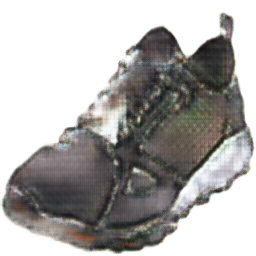

In [23]:
from IPython.display import Image

Image('./generated/generated-images-0001.png')

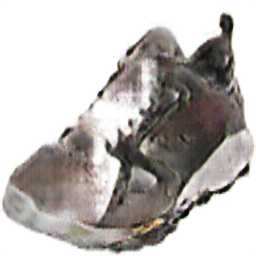

In [24]:
Image('./generated/generated-images-0005.png')

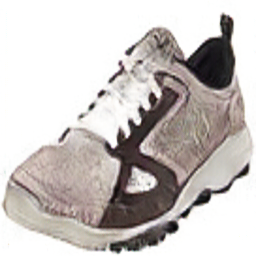

In [25]:
Image('./generated/generated-images-0050.png')

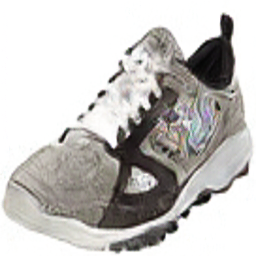

In [26]:
Image('./generated/generated-images-0100.png')

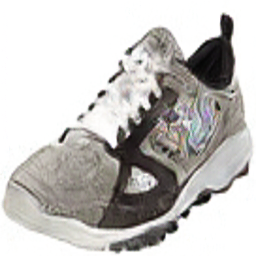

In [27]:
Image('./generated/generated-images-0100.png')

## Plotting Loss of Generator & Discriminator

In [28]:
epochs_range = list(range(1, len(losses_d) + 1))

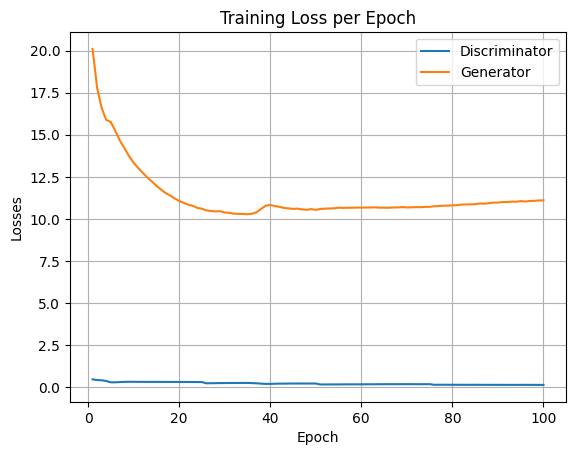

In [29]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Real & Fake Scores

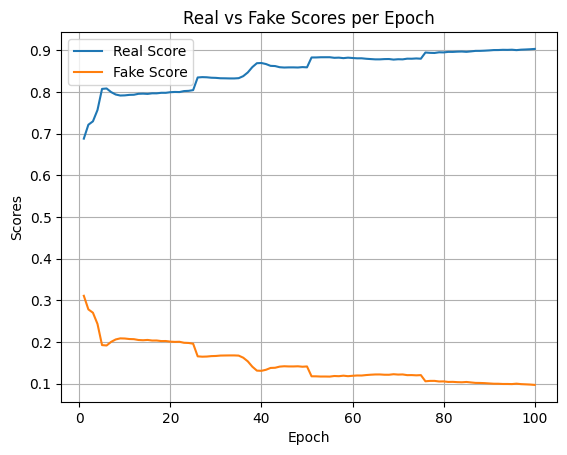

In [30]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Generating New Images

In [42]:
test_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((256, 512)),
])

In [46]:
# Building a validation loader
val_ds  = Pix2PixDataset('./data/edges2shoes', mode='val',
                          full_transform=test_transform,
                          to_tensor=to_tensor_norm)
val_dl  = DataLoader(val_ds, batch_size=100, shuffle=False, num_workers=0)

In [47]:
from PIL import Image as PILImage

generator = Pix2PixGenerator()
generator.load_state_dict(torch.load('G.pth'))
generator.eval()

# Sampling from val_dl
street_batch, _ = next(iter(val_dl))
fake_batch = generator(street_batch)
fake_batch = denorm(fake_batch)
real_batch = denorm(street_batch)  

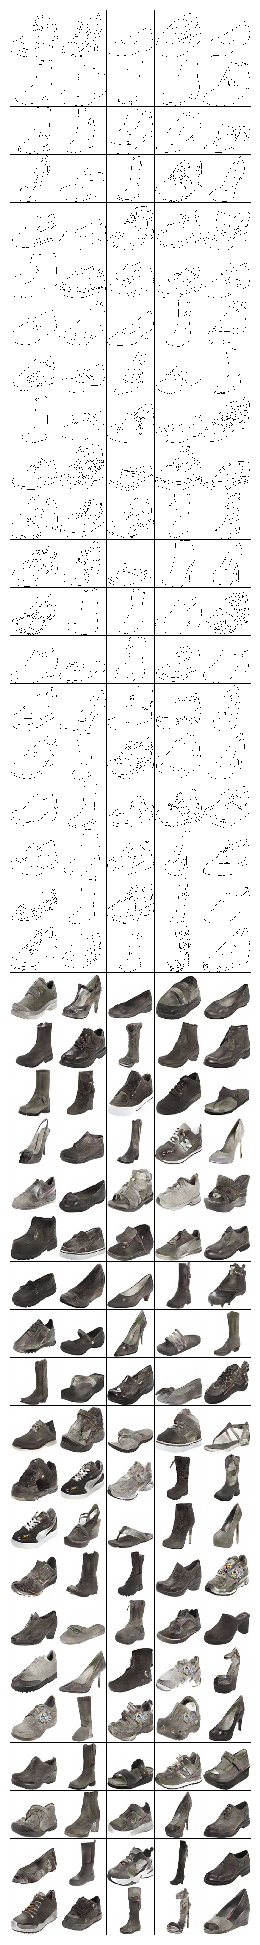

In [48]:
# Display Images
real_grid = make_grid(real_batch, nrow=5)
fake_grid = make_grid(fake_batch, nrow=5)

combined = torch.cat([real_grid, fake_grid], dim=1)

img = combined.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 25), dpi=100)
plt.axis('off')
plt.imshow(img, interpolation='nearest')
plt.show()

## User Interface

In [ ]:
from torchvision.transforms import ToPILImage
import PIL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Pix2PixGenerator().to(device)

checkpoint_path = "G.pth"
state_dict = torch.load(r'T:\checkpoint_gen_epoch300.pth', map_location=device)
generator.load_state_dict(state_dict)

generator.eval()

infer_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((256, 512)),
])

def translate(sketch_img: PIL.Image.Image) -> PIL.Image.Image:
    img = infer_transform(sketch_img)
    sketch = to_tensor_norm(img.crop((0, 0, 256, 256)))
    x = sketch.unsqueeze(0).to(device)
    
    with torch.no_grad():
        fake = generator(x)

    out = denorm(fake[0]).clamp(0, 1)

    return ToPILImage()(out)


In [ ]:
iface = gr.Interface(
    fn=translate,
    inputs=gr.Image(type="pil", label="Input Sketch"),
    outputs=gr.Image(type="pil", label="Generated Shoe"),
    title="Sketch2Shoe",
    description="Upload a shoe sketch; get a photorealistic footwear image."
)

In [ ]:
# Launch
iface.launch()